## SNA Using Tweepy Library

### Install and import Tweepy library

In [ ]:
%cd tweepy
!pip install tweepy

In [ ]:
import tweepy
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

### Export API KEY, Secret Key, Token and Bearer

In [ ]:
api_key = ""
api_secret_key = ""
access_token = ""
access_token_secret = ""
bearer_token = ""

### Authorization and sarching tweet using custom query and other param

In [ ]:
# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(api_key, api_secret_key)

# set access to user's access key and access secret 
auth.set_access_token(access_token, access_token_secret)
client_id = ''
client_secret = ''

# calling the api 
api = tweepy.API(auth)
data_tweet = api.search(q='kereta api cepat indonesia -filter:retweets', since_id='1610240448307793923', tweet_mode='extended', lang='id', count=200)

### Take result tweet and put it in dataframe variable

In [ ]:
df_tweepy = pd.DataFrame(columns=['id', 'username', 'tweet']).astype('string')
for tweet in data_tweet:
  df_tweepy = pd.concat([pd.DataFrame([[tweet.id, tweet.user.screen_name, tweet.full_text]], columns=df_tweepy.columns), df_tweepy], ignore_index=True)
df_tweepy.head()

,id,username,tweet
0,1612418847335944200,dododid64453759,@firzahusainInc coba bayangkan aja kalo anies ...


### Create function for cleansing data and drop duplicate data

In [ ]:
def findRTGreat(tweet1, tweet2):
  if len(api.retweets(tweet1)) < len(api.retweets(tweet2)):
    return tweet2
  if len(api.retweets(tweet1)) > len(api.retweets(tweet2)):
    return tweet1
  return tweet2

In [ ]:
def findRTid(tweet_id, df_id):
  i = 0
  while i < len(df_id):
    if df_id.iloc[i, 0] == tweet_id:
      return i
    i += 1
  return "error" 

### Algorithm for cleansing data

In [ ]:
def delDuplicate(tweet_ori):
  df_clean_tweepy = tweet_ori
  i = 0
  while i < len(df_clean_tweepy):
    door = True
    del_row = []
    j = i+1
    while j < len(df_clean_tweepy):
      if df_clean_tweepy.iloc[i, 1] == df_clean_tweepy.iloc[j, 1]:
        id = findRTGreat(df_clean_tweepy.iloc[i, 0], df_clean_tweepy.iloc[j, 0])
        index = findRTid(id, df_clean_tweepy)
        del_row.append(index)
        door = False
      j+=1
    if not door:
      df_clean_tweepy = df_clean_tweepy.drop(del_row)
      df_clean_tweepy = df_clean_tweepy.reset_index(drop=True)
    i+=1
  return df_clean_tweepy

In [ ]:
df_clean_tweepy = delDuplicate(df_tweepy)

### Result data

In [ ]:
df_clean_tweepy.head()

,id,username,tweet
0,1612418847335944200,dododid64453759,@firzahusainInc coba bayangkan aja kalo anies ...


### Algorithm for create node and edge so it can be analysis and calculated

In [ ]:
df_KA_tweepy = pd.DataFrame(columns=['username_tweet', 'username_retweet'])
i = 0
while i < len(df_clean_tweepy):
  # looping (ngambil username yang nge retweet suatu post tweet n)
  for x in api.retweets(df_clean_tweepy.iloc[i, 0]):
  # masukin username_retweet sepasang dengan username_tweet
    df_KA_tweepy = pd.concat([pd.DataFrame([[df_clean_tweepy.iloc[i, 1], x.user.screen_name]], columns=df_KA_tweepy.columns), df_KA_tweepy], ignore_index=True)
  i += 1
df_KA_tweepy.head()

,username_tweet,username_retweet


### This part will concate new data and old data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FullDetail_KA.csv to FullDetail_KA (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FullTweet_KA.csv to FullTweet_KA (1).csv


In [ ]:
df_FullTweet_KA = pd.read_csv('FullTweet_KA.csv')
df_FullDetail_KA = pd.read_csv('FullDetail_KA.csv')

df_FT_KA = df_FullTweet_KA.drop(df_FullTweet_KA.columns[[0]],axis = 1)
df_FD_KA = df_FullDetail_KA.drop(df_FullDetail_KA.columns[[0]],axis = 1)

In [ ]:
df_FullTweet_KA = df_KA_tweepy.append(df_FT_KA, ignore_index=True)
df_FullDetail_KA = df_clean_tweepy.append(df_FD_KA, ignore_index=True)

### Visualitation data degree centrality using networkx library

In [ ]:
list_degree = df_FullTweet_KA[["username_retweet", "username_tweet"]].copy()
list_degree = list_degree.values.tolist()

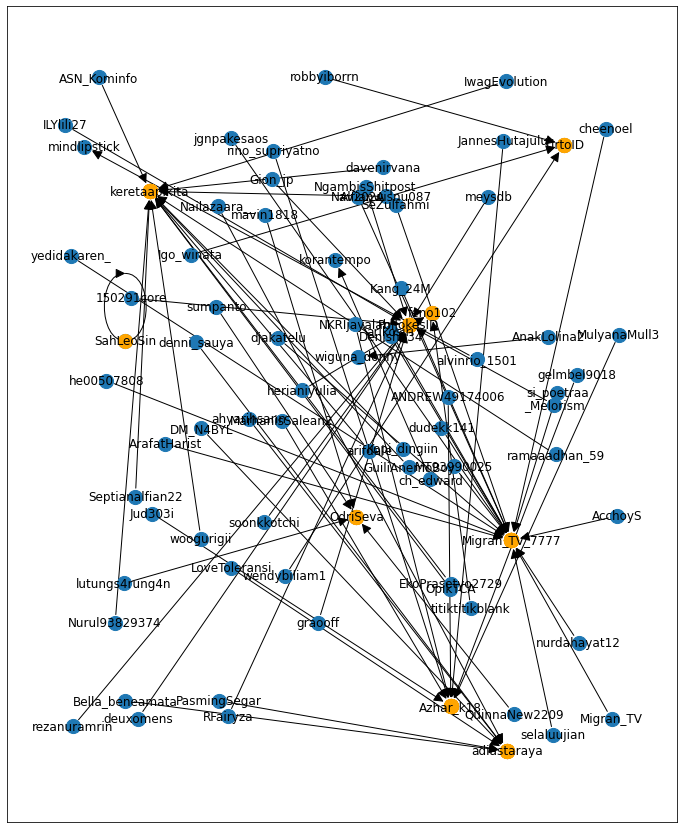

In [ ]:
g = nx.DiGraph()
g.add_edges_from(list_degree)
labels = [i for i in dict(g.nodes).keys()]
labels = {i:i for i in dict(g.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,15))
layout = nx.random_layout(g)
nx.draw_networkx_nodes(g, layout, ax=ax, label=True, node_size=200)
nx.draw_networkx_edges(g, layout, ax=ax, arrowsize=20)
_ = nx.draw_networkx_labels(g, layout, labels, ax=ax)

influencer = [x for x in df_FullTweet_KA.username_tweet if g.degree(x)>1]
nx.draw_networkx_nodes(g, layout, nodelist=influencer, node_color='orange', node_size=200)

## Jumlah retweet (in_degree) per post dalam suatu node (akun yang memposting tweet)

In [ ]:
degree = dict(g.degree(g.nodes()))
df_degree = pd.DataFrame(columns=['username', 'in_degree'])
for index in degree:
  df_degree = pd.concat([pd.DataFrame([[index, degree[index]]], columns=df_degree.columns), df_degree], ignore_index=True)
df_degree_sorted = df_degree.sort_values(by=['in_degree'], ascending=False).head()
df_degree_sorted

,username,in_degree
18,Migran_TV_7777,18
80,keretaapikita,13
47,PolJokesID,11
27,Azhar_k18,8
60,adiastaraya,7


## Normalized by the maximum possible degree

In [ ]:
def norm(df_degree, index):
  return df_degree.iloc[index, 1]/(len(df_degree)-1)

In [ ]:
df_norm = pd.DataFrame(columns=['username', 'normalized'])
i = 0
while i < len(df_degree):
  df_norm = pd.concat([pd.DataFrame([[df_degree.iloc[i,0], norm(df_degree, i)]], columns=df_norm.columns), df_norm], ignore_index=True)
  i+=1
df_norm_sorted = df_norm.sort_values(by=['normalized'], ascending=False).head()
df_norm_sorted

,username,normalized
62,Migran_TV_7777,0.2250
0,keretaapikita,0.1625
33,PolJokesID,0.1375
53,Azhar_k18,0.1000
20,adiastaraya,0.0875


## Freeman’s Network Centrality, To check heterogeneity (how much variation there is among the nodes)

In [ ]:
def freeMN(df_degree):
  i = 0
  value = 0
  while i < len(df_degree):
    value+= (df_degree['in_degree'].max() - df_degree.iloc[i, 1])
    i+=1
  return value/((len(df_degree)-1)*(len(df_degree)-2))

In [ ]:
variation = freeMN(df_degree)
print("Banyaknya variasi centrality diantara node sebanyak : ", variation)

Banyaknya variasi centrality diantara node sebanyak :  0.20854430379746836


## 5 Post tweet yang paling mempengaruhi akun lain berdasarkan jumlah retweet

In [ ]:
def findId(df_fulldetail, username):
  i = 0
  while i < len(df_fulldetail):
    if username == df_fulldetail.iloc[i, 1]:
      return df_fulldetail.iloc[i, 0]
    i+=1
  return None

In [ ]:
def find5Influence(df_fulldetail, df_degree_sorted, df_norm_sorted):
  df_5influence = pd.DataFrame(columns=['id_tweet', 'username', 'tweet', 'in_degree', 'normalized'])
  i = 0
  while i < 5:
    status = api.get_status(findId(df_FullDetail_KA, df_degree_sorted.iloc[i,0]))
    df_5influence = pd.concat([pd.DataFrame([[status.id, status.user.name,  status.text, df_degree_sorted.iloc[i,1], df_norm_sorted.iloc[i,1]]], columns=df_5influence.columns), df_5influence], ignore_index=True)
    i+=1
  return df_5influence

In [ ]:
df_influencer = find5Influence(df_FullDetail_KA, df_degree_sorted, df_norm_sorted)
df_influencer.sort_values(by=['normalized'], ascending=False).head()

,id_tweet,username,tweet,in_degree,normalized
4,1599996413647417344,Migran TV,Woi @DPR_RI kapan Kelen bikin pansus Kereta A...,18,0.2250
3,1610139064044498945,Kereta Api Kita,PT Kereta Api Indonesia (Persero) telah meneri...,13,0.1625
2,1603948334078922752,Political Jokes ID,Denger-denger kereta api cepat kalau utangnya ...,11,0.1375
1,1600063536469680129,Azhar,"Ini yg kita nanti. \nSyukur alhamdulillah, akh...",8,0.1000
0,1605806196610322433,adiastaraya,Pentingnya instruksi dari pimpinan agar di dae...,7,0.0875


## Visualisasi 5 akun yang paling berpengaruh menggunakan pie chart

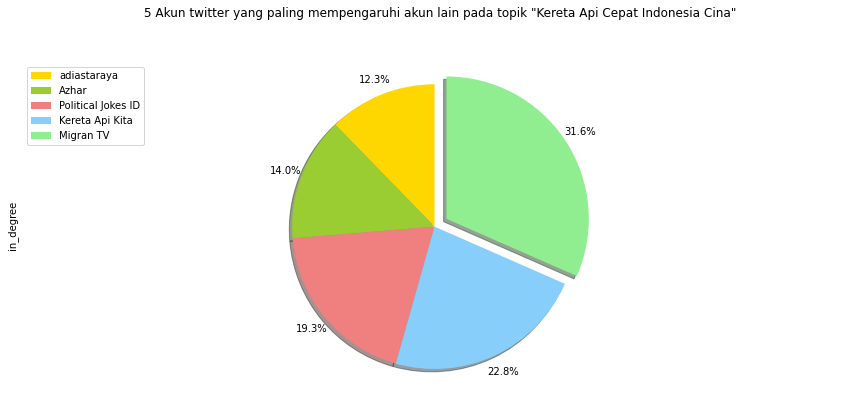

In [ ]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode_list = [0, 0, 0, 0, 0.1]

df_influencer['in_degree'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         
                            pctdistance=1.12,    
                            colors=colors_list,  
                            explode=explode_list 
                            )

plt.title('5 Akun twitter yang paling mempengaruhi akun lain pada topik "Kereta Api Cepat Indonesia Cina"', y=1.12) 
plt.axis('equal') 
plt.legend(labels=df_influencer['username'], loc='upper left') 
plt.show()

In [ ]:
df_FullTweet_KA.to_csv('FullTweet_KA.csv')
df_FullDetail_KA.to_csv('FullDetail_KA.csv')
df_influencer.to_csv('5Influencer_KA.csv')